# **02 - preprocesado**

We are going to load the analyzed data in the notebook "01 - exploración de datos.ipynb", we will do the processing that we consider necessary in this section to finally leave a dataset ready to be used by a deep leraning model

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
# Mount Google Drive
drive.mount('/content/drive')
# Load the CSV file into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/data.csv', index_col=0)

#Checking data types of each variable
print('Data shape: {}'.format(data.shape))
print(data.dtypes)
#Checking shape and displaying first 10 rows of data
data.head(10).T


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data shape: (101766, 24)
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
number_diagnoses             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
glimepiride                 object
glipizide                   object
glyburide                   object
pioglitazone                object
rosiglitazone               object
insulin                     object
change                      object
diabetesMed                 object
readmitted                   int64
dtype:

,0,1,2,3,4,5,6,7,8,9
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12
number_diagnoses,1,9,6,7,5,9,7,8,8,8
num_lab_procedures,41,59,11,44,51,31,70,73,68,33


From the analysis of the last notebook '01 - exploración de datos.ipynb' we know that there are some fields that are missing some characteristics, we proceed to treat this data:

In [65]:
#We divide the data by classes, the idea is to keep the largest amount of data from class 1
data_0 = data.loc[data['readmitted'] == 0]
data_1 = data.loc[data['readmitted'] == 1]

#patient_nbr: Unique identifier of a patient, keep only the first record of each patient
data_0 = data_0.drop_duplicates(subset='patient_nbr', keep='first')
#We delete the records of the data that are missing
data_0 = data_0[(data_0['race'] != '?')]
data_0 = data_0[(data_0['gender'] != 'Unknown/Invalid')]
#We removed users whose hospitalization ended in death
data_0 = data_0.loc[~data_0['discharge_disposition_id'].isin([11, 13, 14, 19, 20, 21])]
#For class 1 we replace the data of the breed by the one that presents the most in the readmission
data_1.loc[data_1['race'] == '?', 'race'] = 'Caucasian'

#We put the data back together
data = pd.concat([data_0, data_1], ignore_index=True)
#encounter_id: Unique identifier of an encounter, remove both columns
data = data.drop(columns=['patient_nbr'])

#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in data.columns:
    if data[col].dtype == object:
         print(col,data[col][data[col] == '?'].count())

# gender was coded differently so we use a custom count for this one            
print('gender', data['gender'][data['gender'] == 'Unknown/Invalid'].count())

race 0
gender 0
age 0
max_glu_serum 0
A1Cresult 0
metformin 0
glimepiride 0
glipizide 0
glyburide 0
pioglitazone 0
rosiglitazone 0
insulin 0
change 0
diabetesMed 0
gender 0


Next we proceed to code the categorical variables, turning them numerical, depending on the case, 3 techniques were implemented:

- One-Hot / Dummy Encoding.
- Binary Encoding.
- Label / Ordinal Encoding.

In [66]:
#One-Hot / Dummy Encoding --> race
encoded_race = pd.get_dummies(data['race'], prefix='race')
#Concatenate the encoded columns to the original dataframe
data = pd.concat([data, encoded_race], axis=1)
#Delete the original 'race' column
data.drop('race', axis=1, inplace=True)

In [67]:
#Binary Encoding --> gender, change, diabetesMed
encoder = LabelEncoder()
data['gender'] = encoder.fit_transform(data['gender'])
data['change'] = encoder.fit_transform(data['change'])
data['diabetesMed'] = encoder.fit_transform(data['diabetesMed'])

In [68]:
#Label / Ordinal Encoding --> age, max_glu_serum, A1Cresult, metformin,
#glimepiride, glyburide, pioglitazone, pioglitazone, rosiglitazone, insulin
age_mapping = {
    '[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4,
    '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9
}
max_glu_serum_mapping = {
    'None': 0, 'Norm': 1, '>200': 2, '>300': 3
}
A1Cresult_mapping = {
    'None': 0, 'Norm': 1, '>7': 2, '>8': 3
}
drug_mapping = {
    'No': 0, 'Steady': 1, 'Down': 2, 'Up': 3
}

data['age'] = data['age'].map(age_mapping)
data['max_glu_serum'] = data['max_glu_serum'].map(max_glu_serum_mapping)
data['A1Cresult'] = data['A1Cresult'].map(A1Cresult_mapping)
data['metformin'] = data['metformin'].map(drug_mapping)
data['glimepiride'] = data['glimepiride'].map(drug_mapping)
data['glipizide'] = data['glipizide'].map(drug_mapping)
data['glyburide'] = data['glyburide'].map(drug_mapping)
data['pioglitazone'] = data['pioglitazone'].map(drug_mapping)
data['rosiglitazone'] = data['rosiglitazone'].map(drug_mapping)
data['insulin'] = data['insulin'].map(drug_mapping)

In [69]:
#Checking shape and displaying first 10 rows of data
print(data.dtypes)
data.head(10).T

gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
number_diagnoses            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
glimepiride                 int64
glipizide                   int64
glyburide                   int64
pioglitazone                int64
rosiglitazone               int64
insulin                     int64
change                      int64
diabetesMed                 int64
readmitted                  int64
race_AfricanAmerican        uint8
race_Asian                  uint8
race_Caucasian              uint8
race_Hispanic               uint8
race_Other                  uint8
dtype: object


,0,1,2,3,4,5,6,7,8,9
gender,0,0,0,1,1,1,1,1,0,0
age,0,1,2,3,4,5,6,7,8,9
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12
number_diagnoses,1,9,6,7,5,9,7,8,8,8
num_lab_procedures,41,59,11,44,51,31,70,73,68,33
num_procedures,0,0,5,1,0,6,1,0,2,3
num_medications,1,18,13,16,8,16,21,12,28,18


Once the data has been processed, we proceed to the analysis of the response variable, reviewing how its distribution changed with the procedure.

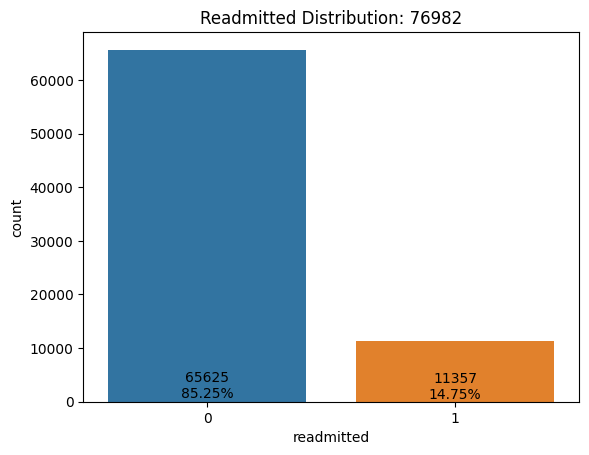

In [70]:
# Classes distribution
readmitted_counts = data['readmitted'].value_counts()
bars = round(data['readmitted'].value_counts(normalize=True)[[0, 1]] * 100, 2).values

sns.countplot(x=data["readmitted"]).set_title('Readmitted Distribution: '+str(data.shape[0]))

# Labels
for i, bar in enumerate(bars):
    plt.annotate(str(readmitted_counts[i])+'\n'+str(bar)+'%', xy=(i, bar), ha='center', va='bottom')
plt.show()

We see that the distribution of class 1 rose a bit, however the data is still very uneven, here we decided to balance the data, there are 2 ways:

- Sub-sample the more dominant class
- Over-sample the imbalanced class

We tried both ways and got better results with the first option.

In [71]:
#Sub-sample the more dominant class
#Split the data into positive and negative
data_0 = data.loc[data['readmitted'] == 0]
data_1 = data.loc[data['readmitted'] == 1]

#merge de balance data
data = pd.concat([data_1, data_0.sample(n = len(data_1))], axis=0)
#shuffle the order of training samples
data = data.sample(n=len(data)).reset_index(drop=True)

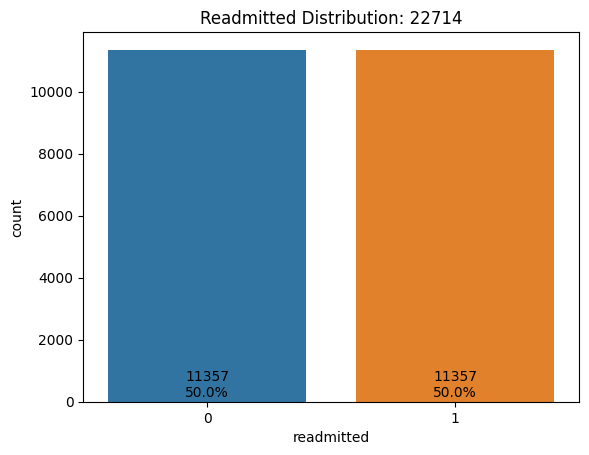

In [72]:
# Classes distribution
readmitted_counts = data['readmitted'].value_counts()
bars = round(data['readmitted'].value_counts(normalize=True)[[0, 1]] * 100, 2).values

sns.countplot(x=data["readmitted"]).set_title('Readmitted Distribution: '+str(data.shape[0]))

# Labels
for i, bar in enumerate(bars):
    plt.annotate(str(readmitted_counts[i])+'\n'+str(bar)+'%', xy=(i, bar), ha='center', va='bottom')
plt.show()

In this way, you consider that the data is already processed and ready to be used in a deep learnng model, therefore we proceed to save the data to be used in the last module "03 - arquitectura de linea de base.ipynb".

In [73]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
data.to_csv('/content/drive/MyDrive/processedData.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
